<a href="https://colab.research.google.com/github/azeem110201/Captcha-Recognition/blob/master/Captcha_Recognition_Easy_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras import layers
from keras.models import Model
from keras.models import load_model
from keras import callbacks
import os
import cv2
import string
import numpy as np

#Init main values
symbols = string.ascii_lowercase + "0123456789" # All symbols captcha can contain
num_symbols = len(symbols)
img_shape = (50, 200, 1)

Using TensorFlow backend.


In [2]:
print(num_symbols)

36


In [3]:
def create_model():
    img = layers.Input(shape=img_shape) # Get image as an input and process it through some Convs
    conv1 = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(img)
    mp1 = layers.MaxPooling2D(padding='same')(conv1)  # 100x25
    conv2 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp1)
    mp2 = layers.MaxPooling2D(padding='same')(conv2)  # 50x13
    conv3 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp2)
    bn = layers.BatchNormalization()(conv3)
    mp3 = layers.MaxPooling2D(padding='same')(bn)  # 25x7
    
    # Get flattened vector and make 5 branches from it. Each branch will predict one letter
    flat = layers.Flatten()(mp3)
    outs = []
    for _ in range(5):
        dens1 = layers.Dense(64, activation='relu')(flat)
        drop = layers.Dropout(0.5)(dens1)
        res = layers.Dense(num_symbols, activation='sigmoid')(drop)

        outs.append(res)
    
    # Compile model and return it
    model = Model(img, outs)
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=["accuracy"])
    return model

In [4]:
def preprocess_data():
    n_samples = len(os.listdir('/content/drive/My Drive/captcha recognition/samples/samples'))
    X = np.zeros((n_samples, 50, 200, 1)) #1070*50*200
    y = np.zeros((5, n_samples, num_symbols)) #5*1070*36

    for i, pic in enumerate(os.listdir('/content/drive/My Drive/captcha recognition/samples/samples')):
        # Read image as grayscale
        img = cv2.imread(os.path.join('/content/drive/My Drive/captcha recognition/samples/samples', pic), cv2.IMREAD_GRAYSCALE)
        pic_target = pic[:-4]
        if len(pic_target) < 6:
            # Scale and reshape image
            img = img / 255.0
            img = np.reshape(img, (50, 200, 1))
            # Define targets and code them using OneHotEncoding
            targs = np.zeros((5, num_symbols))
            for j, l in enumerate(pic_target):
                ind = symbols.find(l)
                targs[j, ind] = 1
            X[i] = img
            y[:, i] = targs
    
    # Return final data
    return X, y

X, y = preprocess_data()
X_train, y_train = X[:970], y[:, :970]
X_test, y_test = X[970:], y[:, 970:]

In [5]:
model=create_model()

In [6]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50, 200, 1)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 50, 200, 16)  160         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 25, 100, 16)  0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 25, 100, 32)  4640        max_pooling2d_1[0][0]            
____________________________________________________________________________________________

In [7]:
history = model.fit(X_train, [y_train[0], y_train[1], y_train[2], y_train[3], y_train[4]], batch_size=32, epochs=70,verbose=1, validation_split=0.2)

Train on 776 samples, validate on 194 samples
Epoch 1/70
776/776 [==============================] - 9s 11ms/step - loss: 17.4271 - dense_2_loss: 3.3948 - dense_4_loss: 3.5260 - dense_6_loss: 3.5224 - dense_8_loss: 3.5002 - dense_10_loss: 3.4933 - dense_2_accuracy: 0.0515 - dense_4_accuracy: 0.0412 - dense_6_accuracy: 0.0683 - dense_8_accuracy: 0.0515 - dense_10_accuracy: 0.0619 - val_loss: 17.6422 - val_dense_2_loss: 3.5389 - val_dense_4_loss: 3.5192 - val_dense_6_loss: 3.5233 - val_dense_8_loss: 3.5288 - val_dense_10_loss: 3.5263 - val_dense_2_accuracy: 0.0000e+00 - val_dense_4_accuracy: 0.0515 - val_dense_6_accuracy: 0.0309 - val_dense_8_accuracy: 0.0412 - val_dense_10_accuracy: 0.0876
Epoch 2/70
776/776 [==============================] - 7s 9ms/step - loss: 16.4027 - dense_2_loss: 3.1425 - dense_4_loss: 3.2871 - dense_6_loss: 3.2731 - dense_8_loss: 3.3616 - dense_10_loss: 3.3242 - dense_2_accuracy: 0.0722 - dense_4_accuracy: 0.0670 - dense_6_accuracy: 0.0760 - dense_8_accuracy: 0.04

In [30]:
model.save('captcha_simple_model.h5')

In [8]:
# Define function to predict captcha
def predict(filepath):
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    
    if img is not None:
        img = img / 255.0
    else:
        print("Not detected");
    res = np.array(model.predict(img[np.newaxis, :, :, np.newaxis]))
    ans = np.reshape(res, (5, 36))
    l_ind = []
    probs = []
    for a in ans:
        l_ind.append(np.argmax(a))
        #probs.append(np.max(a))

    capt = ''
    for l in l_ind:
        capt += symbols[l]
    return capt#, sum(probs) / 5

In [11]:
score= model.evaluate(X_test,[y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]],verbose=1)
print('Test Loss and accuracy:', np.mean(score))

100/100 [==============================] - 0s 3ms/step
Test Loss and accuracy: 0.666548470875079


In [12]:
model.evaluate(X_test, [y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]])
print(predict('/content/drive/My Drive/captcha recognition/samples/samples/8n5p3.png'))
print(predict('/content/drive/My Drive/captcha recognition/samples/samples/f2m8n.png'))
print(predict('/content/drive/My Drive/captcha recognition/samples/samples/dce8y.png'))
print(predict('/content/drive/My Drive/captcha recognition/samples/samples/3eny7.png'))
print(predict('/content/drive/My Drive/captcha recognition/samples/samples/npxb7.png'))

100/100 [==============================] - 0s 3ms/step
8n5p3
f2m8n
dce8y
3eny7
npxb7


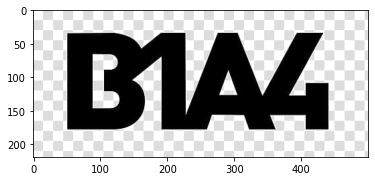

In [22]:
%matplotlib inline 
import matplotlib.pyplot as plt
img=cv2.imread('/content/drive/My Drive/captcha recognition/captcha_2.png',cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap=plt.get_cmap('gray'))